In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.scipy.stats import multivariate_normal
from jax.scipy.special import logsumexp
from jax.tree_util import tree_structure

In [2]:
import genjax
console = genjax.pretty()

In [3]:
import gi

In [4]:
normalize = lambda xs: xs / xs.sum()
normalize_logs = lambda lxs: lxs - logsumexp(lxs)
log_normalize = lambda xs: jnp.log(xs) - jnp.log(xs.sum())

In [5]:
key = jax.random.PRNGKey(2718)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [6]:
N = 5 # oy
@genjax.gen
def model_mv(xmean: float, ymean: float, posvar: float, obsvar: float):
    #x = genjax.normal(xmean, posvar) @ 'x'
    #y = genjax.normal(ymean, posvar) @ ('weirdness', 'y')
    #obs_mean = jnp.array([x, y])
    obs_mean = genjax.mv_normal(jnp.array([xmean, ymean]), posvar * jnp.eye(2)) @ 'obs_mean'
    for i in range(N):
        genjax.mv_normal(obs_mean, obsvar * jnp.eye(2)) @ ('obs', i)

In [7]:
XMEAN, YMEAN, POSVAR, OBSVAR =  0.0, 0.0, 10.0, 4.0

In [8]:
_, tr = model_mv.simulate(key, (XMEAN, YMEAN, POSVAR, OBSVAR))

In [9]:
def viz_posterior(ax, obss, pos=None, show_obs=True):
    var = POSVAR * OBSVAR / (OBSVAR + N*POSVAR)  # posterior var
    mean = var * (jnp.array([XMEAN, YMEAN])/POSVAR + obss.sum(axis=0) / OBSVAR) # posterior mean
    logpdf = gi.multivmap(lambda x, y: genjax.mv_normal.logpdf(jnp.array([x, y]), mean, var * jnp.eye(2)))
    imxs = jnp.linspace(mean[0]-2*OBSVAR, mean[0]+2*OBSVAR, 100)
    imys = jnp.linspace(mean[1]-2*OBSVAR, mean[1]+2*OBSVAR, 100)
    x_min, x_max, y_min, y_max = mean[0]-2*OBSVAR, mean[0]+2*OBSVAR, mean[1]-2*OBSVAR, mean[1]+2*OBSVAR
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    img = jnp.exp(logpdf(imxs, imys))
    ax.imshow(img, extent=(x_min, x_max, y_min, y_max), origin='lower')
    if show_obs:
        ax.scatter(obss[:, 0], obss[:, 1], marker='o', c='r')
    if pos is not None:
        ax.scatter([pos[0]], [pos[1]], marker='o', c='w')

In [10]:
obss = jnp.array([tr[('obs', i)] for i in range(N)])

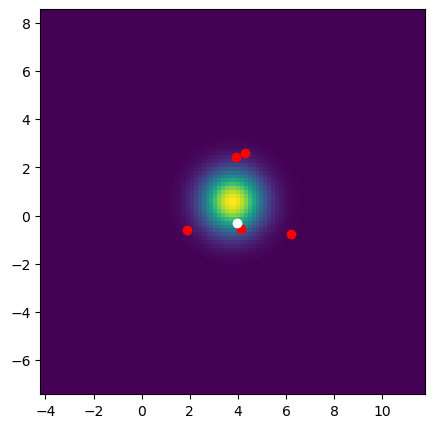

In [11]:
fig, ax = plt.subplots(figsize=(5, 5))
viz_posterior(ax, obss, pos=tr['obs_mean'])

In [12]:
init_trp = gi.TracePartition.from_trace(tr,
    {'obs_mean': gi.RegularIntervalPartition(-4, 12, 10) * gi.RegularIntervalPartition(-7, 9, 10)})

scoring_strats = [
    gi.TraceScoringStrategy({
        'obs_mean': gi.EuclideanBoxQuadrature([gi.IntervalQuadrature(4),
                                               gi.IntervalQuadrature(4)])
    }),
    
    gi.TraceScoringStrategy({
        'obs_mean': gi.EuclideanBoxQuadrature([gi.IntervalQuadrature(2),
                                               gi.IntervalQuadrature(2)])
    })
]

refinement_strats = [
    gi.TraceRefinementStrategy({
        'obs_mean': gi.EuclideanBoxEquidissection([gi.IntervalEquidissection(3), 
                                                   gi.IntervalEquidissection(3)])
    })
]

In [13]:
strat = gi.C2FStrategy(init_trp, refinement_strats, scoring_strats)

In [14]:
sampler = gi.C2FSampler(model_mv, (XMEAN, YMEAN, POSVAR, OBSVAR), strat) 

In [15]:
def viz_trp(ax, trp):
    xpart, ypart = trp['obs_mean'].factors
    ax.set_xticks(xpart.part_pts)
    ax.set_yticks(ypart.part_pts)
    ax.vlines(xpart.part_pts, ypart.left, ypart.right, color='grey')
    ax.hlines(ypart.part_pts, xpart.left, xpart.right, color='grey')

In [16]:
def viz_scoring(ax, trp, scoring_strat):
    viz_trp(ax, trp)
    xsgrid, ysgrid = jnp.meshgrid(*scoring_strat.get_scoring_pts(trp)[0].T)
    ax.scatter(xsgrid.flatten(), ysgrid.flatten(), color='r', marker='o', s=1)

In [17]:
init_trp

TracePartition
└── addprs
    └── Trie
        ├── :obs
        │   └── Trie
        │       ├── :0
        │       │   └── FixedCoordinate
        │       │       └── val
        │       │           └──  f32[2]
        │       ├── :1
        │       │   └── FixedCoordinate
        │       │       └── val
        │       │           └──  f32[2]
        │       ├── :2
        │       │   └── FixedCoordinate
        │       │       └── val
        │       │           └──  f32[2]
        │       ├── :3
        │       │   └── FixedCoordinate
        │       │       └── val
        │       │           └──  f32[2]
        │       └── :4
        │           └── FixedCoordinate
        │               └── val
        │                   └──  f32[2]
        └── :obs_mean
            └── EuclideanBoxPartition
                └── factors
                    └── tuple
                        ├── RegularIntervalPartition
                        │   └── part_pts
                        │       └──  f32[11]
                        └── RegularIntervalPartition
                            └── part_pts
                                └──  f32[11]

In [18]:
sampler_jit = jax.jit(sampler.sample)

In [33]:
ch = sampler_jit(key)
key = jax.random.split(key, 1)[0]
ch['obs_mean']

Array([ 3.568723  , -0.39024907], dtype=float32)

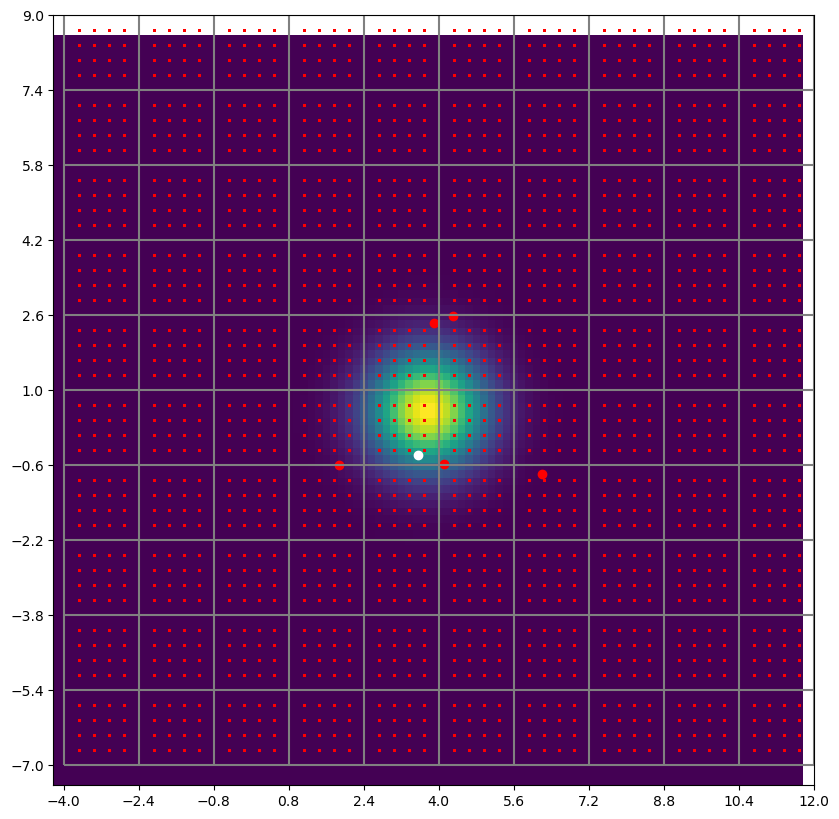

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
viz_posterior(ax, obss, show_obs=True, pos=ch['obs_mean'])
viz_scoring(ax, init_trp, scoring_strats[0])